In [1]:
from utils import generate_SUR, Sampler, DefaultParams
import numpy as np
from numpy.linalg import inv
from scipy.stats import invwishart, invgamma

import matplotlib.pyplot as plt

In [2]:
params = DefaultParams()

In [13]:
class MCMC_Sampler(Sampler):
    def __init__(self, SUR_data, num_iterations=11000, burn_in_steps=1000):
        super().__init__(SUR_data)
        self.num_iterations = num_iterations
        self.burn_in_steps = burn_in_steps

    def _sample_beta(self, omega):
        omega_inv = inv(omega)
        n = params.n
        omega_inv_tensor = np.block([
                        [omega_inv[0,0]*np.eye(n), omega_inv[0,1]*np.eye(n)],
                        [omega_inv[1,0]*np.eye(n), omega_inv[1,1]*np.eye(n)],
        ])
        X = self.SUR_data['X']
        Y = self.SUR_data['Y']
        X_transposed = np.transpose(X)
        beta_hat = inv(X_transposed @ omega_inv_tensor @ X) @ X_transposed @ omega_inv_tensor @ Y
        omega_hat = inv(X_transposed @ omega_inv_tensor @ X)
        beta = np.random.multivariate_normal(mean=beta_hat.reshape(-1,), cov=omega_hat)
        return beta

    def _sample_omega(self, beta):
        y1 = self.SUR_data['Y'][:100]
        y2 = self.SUR_data['Y'][100:]
        x1 = self.SUR_data['x1']
        x2 = self.SUR_data['x2']
        m1 = y1 - x1 @ beta[:2].reshape(-1,1)
        m2 = y2 - x2 @ beta[2:].reshape(-1,1)
        R = np.array([[(np.transpose(m1) @ m1).item(), (np.transpose(m1) @ m2).item()],
                      [(np.transpose(m2) @ m1).item(), (np.transpose(m2) @ m2).item()]])
        omega = invwishart.rvs(df=params.n, scale=R)
        return omega

    def sample(self):
        beta_simu = []
        omega_simu = []
        # initialisation
        omega = np.random.rand(2,2)
        for _ in range(self.num_iterations):
            beta = self._sample_beta(omega)
            omega = self._sample_omega(beta)
            beta_simu.append(beta)
            omega_simu.append(omega)
        return np.array(beta_simu[self.burn_in_steps:]), np.array(omega_simu[self.burn_in_steps:])

In [14]:
mcmc_sampler = MCMC_Sampler(SUR_data=generate_SUR())
beta_simu, omega_simu = mcmc_sampler.sample()

C:\Users\槐序有陆\AppData\Local\Temp\ipykernel_45260\1518117048.py:18: RuntimeWarning: covariance is not positive-semidefinite.
  beta = np.random.multivariate_normal(mean=beta_hat.reshape(-1,), cov=omega_hat)


In [17]:
def plot_beta(beta):
    plt.plot(beta[:,0], label='beta11')
    plt.plot(beta[:,1], label='beta12')
    plt.plot(beta[:,2], label='beta21')
    plt.plot(beta[:,3], label='beta22')
    plt.xlabel("#Iterations")
    plt.title("Gibbs sampler")
    plt.ylim(-3, 4)
    plt.legend()
    plt.show()

In [18]:
def plot_omega(omega):
    plt.plot(omega[:,0,0], label='omega1')
    plt.plot(omega[:,0,1], label='omega12')
    plt.plot(omega[:,1,1], label='omega2')
    plt.xlabel("#Iterations")
    plt.title("Gibbs sampler")
    # plt.ylim(-0.1, 0.3)
    plt.legend()
    plt.show()

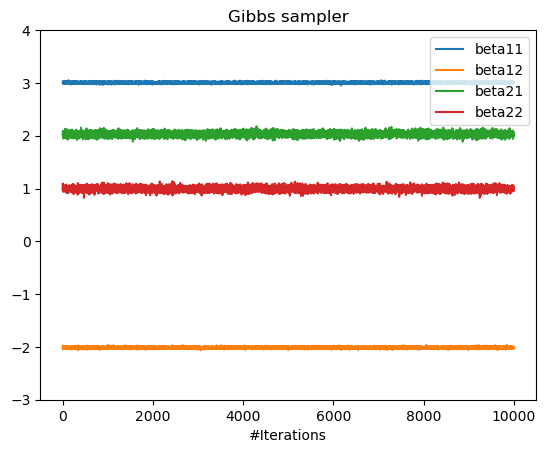

In [19]:
plot_beta(beta=beta_simu)

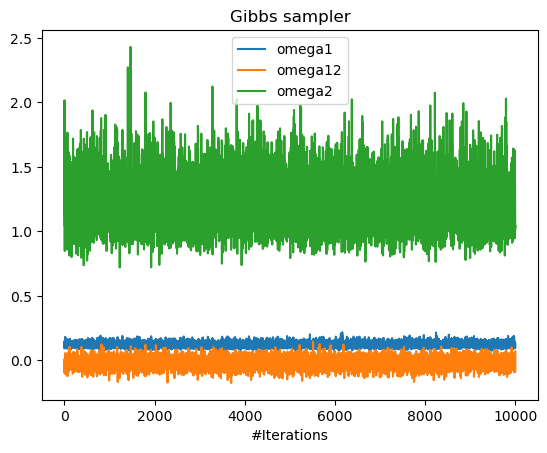

In [20]:
plot_omega(omega=omega_simu)

In [11]:
# def sample_beta(omega, data:generate_SUR):
#     omega_inv = inv(omega)
#     omega_inv_tensor = np.block([
#                     [omega_inv[0,0]*np.eye(params.n), omega_inv[0,1]*np.eye(params.n)],
#                     [omega_inv[1,0]*np.eye(params.n), omega_inv[1,1]*np.eye(params.n)],
#     ])
#     X = data['X']
#     Y = data['Y']
#     X_transposed = np.transpose(X)
#     beta_hat = inv(X_transposed @ omega_inv_tensor @ X) @ X_transposed @ omega_inv_tensor @ Y
#     omega_hat = inv(X_transposed @ omega_inv_tensor @ X)
#     beta = np.random.multivariate_normal(mean=beta_hat.reshape(-1,), cov=omega_hat)
#     return beta
# def sample_omega(beta, data:generate_SUR):
#     y1 = data['Y'][:100]
#     y2 = data['Y'][100:]
#     x1 = data['x1']
#     x2 = data['x2']
#     m1 = y1 - x1 @ params.beta1
#     m2 = y2 - x2 @ params.beta2
#     R = np.array([[(np.transpose(m1) @ m1).item(), (np.transpose(m1) @ m2).item()],
#                   [(np.transpose(m2) @ m1).item(), (np.transpose(m2) @ m2).item()],])
#     omega = invwishart.rvs(df=params.n, scale=R)
#     return omega
# def sample(num_iterations=11000, burn_in_steps=1000):
#     beta_simu = []
#     omega_simu = []
#     # initialisation
#     omega = np.random.rand(2,2)
    
#     for _ in range(num_iterations):
#         beta = sample_beta(omega, data)
#         omega = sample_omega(beta, data)
#         beta_simu.append(beta)
#         omega_simu.append(omega)
    
#     return np.array(beta_simu[burn_in_steps:]), np.array(omega_simu[burn_in_steps:])